# **Import Necessary Packages**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install num2words
!pip install pyspellchecker

import numpy as np
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import regex as rex
from spellchecker import SpellChecker
from bs4 import BeautifulSoup
from num2words import num2words
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

# Ensure you have downloaded the stopwords dataset
import nltk
nltk.download('stopwords')
nltk.download('punkt')


Mounted at /content/drive





  Preparing metadata (setup.py) ... done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 11.7 MB/s eta 0:00:00



  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=64fba6fbee1dcb743bb0ff37bb15932e3647f3f3cf1e2c0da70d5fa8a01c64ff

  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac

Successfully built docopt






   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 65.3 MB/s eta 0:00:00




[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Unzipping corpora/stopwords.zip.

[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Main Data**

In [ ]:
splits = {'train': 'yelp_review_full/train-00000-of-00001.parquet', 'test': 'yelp_review_full/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["train"])
df

,label,text
0,4,dr. goldberg offers everything i look for in a...
1,1,"Unfortunately, the frustration of being Dr. Go..."
2,3,Been going to Dr. Goldberg for over 10 years. ...
3,3,Got a letter in the mail last week that said D...
4,0,I don't know what Dr. Goldberg was like before...
...,...,...
649995,4,I had a sprinkler that was gushing... pipe bro...
649996,0,Phone calls always go to voicemail and message...
649997,0,Looks like all of the good reviews have gone t...
649998,4,I was able to once again rely on Yelp to provi...


In [ ]:
df.shape

(650000, 2)

In [ ]:
df.isnull().sum()

,0
label,0
text,0


In [ ]:
df.duplicated().sum()

0

**To convert Yelp ratings into categorical values like "Positive," "Negative," and "Neutral," you could define rules based on the rating scale (often from 0 to 4). Here’s a common way to categorize these ratings:**

- **Ratings 3 and 4: Positive**
- **Rating 2: Neutral**
- **Ratings 0 and 1: Negative**

In [ ]:
def categorize_rating(rating):
    if rating >= 3:
        return "Positive"
    elif rating == 2:
        return "Neutral"
    else:
        return "Negative"

# Apply the function to the rating column
df['sentiment'] = df['label'].apply(categorize_rating)

df.drop(['label'], axis=1, inplace=True)
df

,text,sentiment
0,dr. goldberg offers everything i look for in a...,Positive
1,"Unfortunately, the frustration of being Dr. Go...",Negative
2,Been going to Dr. Goldberg for over 10 years. ...,Positive
3,Got a letter in the mail last week that said D...,Positive
4,I don't know what Dr. Goldberg was like before...,Negative
...,...,...
649995,I had a sprinkler that was gushing... pipe bro...,Positive
649996,Phone calls always go to voicemail and message...,Negative
649997,Looks like all of the good reviews have gone t...,Negative
649998,I was able to once again rely on Yelp to provi...,Positive


# **visualize the distribution of reviews (Positive, Neutral, Negative)**

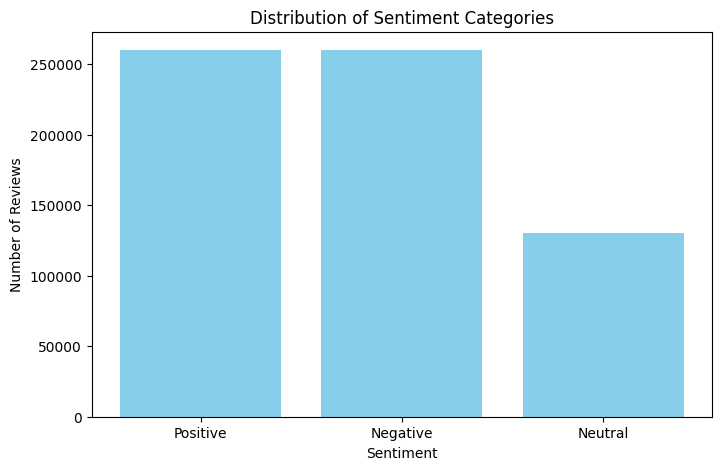

In [ ]:
# Count the values for each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Plot the bar chart using matplotlib
plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.index, sentiment_counts.values, color='skyblue')

# Add labels and title
plt.title("Distribution of Sentiment Categories")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

# **Text Preprocessing**

In [ ]:
df.shape

(650000, 2)

# Cleaning Data

In [ ]:
def clean_text1(text) :
    text = text.lower()
    text = rex.sub(r"[^a-z\s]" , " " , text)
    return text

df["text"] = df["text"].apply(clean_text1)

In [ ]:
def clean_text2(text) :
    corrected_text = []
    spell = SpellChecker()
    for word in text.split() :
        text = spell.correction(word)
        corrected_text.append(text)
    text_correct = " ".join(corrected_text)
    return text_correct

# df["text"] = df["text"].apply(clean_text2)

In [ ]:
def clean_from_tags(text) :
    soup = BeautifulSoup(text , "html.parser")
    corrected_sentence = soup.get_text()
    return corrected_sentence

df["text"] = df["text"].apply(clean_from_tags)

In [ ]:
def clean_url(text) :
    url_pattern = rex.compile(r"https?://\S+|www\.\S+")
    clean = rex.sub(url_pattern , " " , text)
    return clean

df["text"] = df["text"].apply(clean_url)

In [ ]:
def replace_number(text):
    numbers = rex.findall(r"\d+", text)
    for number in numbers:
        # Replace each number in the text with its word representation
        text = text.replace(number, num2words(int(number)))
    return text  # Return the modified text after processing all numbers

df["text"] = df["text"].apply(replace_number)

In [ ]:
def expand_contractions(text):
    # Define a dictionary of common contractions and their expanded forms
    contractions_dict = {
        "u": "you",
        "ur": "your",
        "r": "are",
        "btw": "by the way",
        "lol": "laughing out loud",
        "brb": "be right back",
        "omg": "oh my god",
        "idk": "I don't know",
        "b4": "before",
        "gr8": "great",
        "l8r": "later",
        "pls": "please",
        "thx": "thanks",
        "ttyl": "talk to you later",
        "wtf": "what the heck",
        "imo": "in my opinion",
        "thru": "through",
        "nvm": "never mind",
        "can't": "cannot",
        "won't": "will not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am",
        "i'm": "I am",
        "it's": "it is",
        "he's": "he is",
        "she's": "she is",
        "we're": "we are",
        "they're": "they are",
        "there's": "there is",
        "who's": "who is",
        "that's": "that is",
        "what's": "what is",
        "let's": "let us",
        "i've": "I have",
        "we've": "we have",
        "they've": "they have",
        "should've": "should have",
        "could've": "could have",
        "would've": "would have",
        "you've": "you have",
        "he'd": "he would",
        "she'd": "she would",
        "we'd": "we would",
        "they'd": "they would",
        "i'd": "I would"
    }

    # Ensure that the input is a string
    if isinstance(text, str):
        # Replace contractions using the dictionary
        for contraction, expanded_form in contractions_dict.items():
            # Use word boundaries to avoid partial matches
            text = re.sub(r"\b" + re.escape(contraction) + r"\b", expanded_form, text, flags=re.IGNORECASE)

    return text

df["text"] = df["text"].apply(expand_contractions)

In [ ]:
def remove_emojis_and_emoticons(text):
    # Regular expression pattern to match emojis (covers most emoji ranges)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+", flags=re.UNICODE
    )

    # Regular expression pattern to match common emoticons
    emoticon_pattern = re.compile(r'[:;=8][\-o\*\'"]?[)\(DpP/\:\}\{@\|\\]')

    # Remove emojis
    text = emoji_pattern.sub(r'', text)

    # Remove emoticons
    text = emoticon_pattern.sub(r'', text)

    return text

df["text"] = df["text"].apply(remove_emojis_and_emoticons)

In [ ]:
def remove_emoticons(text):
    # Regular expression pattern to match common emoticons
    emoticon_pattern = re.compile(
        r'[:;=8xX][\-o\*\'"]?[\)\(DpP/\:|O\@\}\{@\|\\]|[><][_.-]?[><]'
    )

    # Remove emoticons from the text
    clean_text = emoticon_pattern.sub(r'', text)

    return clean_text

df["text"] = df["text"].apply(remove_emoticons)

In [ ]:
def stop_words(text) :

  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  filtered_words = [word for word in words if word.lower() not in stop_words]
  cleaned_text = ' '.join(filtered_words)
  return cleaned_text

df["text"] = df["text"].apply(stop_words)

In [ ]:
df

,text,sentiment
0,dr goldberg offers everything look general pra...,Positive
1,unfortunately frustration dr goldberg patient ...,Negative
2,going dr goldberg years think one st patients ...,Positive
3,got letter mail last week said dr goldberg mov...,Positive
4,know dr goldberg like moving arizona let tell ...,Negative
...,...,...
649995,sprinkler gushing pipe broken way ground turne...,Positive
649996,phone calls always go voicemail messages retur...,Negative
649997,looks like good reviews gone head place jason ...,Negative
649998,able rely yelp provide needed response leaking...,Positive


# **Saving Our Cleaning Data**

In [ ]:
df.to_csv("new_yelp.csv", index=True)

# **Load The Dataset After Cleaning**

**Drop "Unnamed: 0" Column**

In [ ]:

df_test = pd.read_parquet("hf://datasets/Yelp/yelp_review_full/" + splits["test"])
df_test['sentiment'] = df_test['label'].apply(categorize_rating)

df_test.drop(['label'], axis=1, inplace=True)

new_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/new_yelp.csv")
new_data.drop(['Unnamed: 0'], axis=1, inplace=True)
new_data


,text,sentiment
0,dr goldberg offers everything look general pra...,Positive
1,unfortunately frustration dr goldberg patient ...,Negative
2,going dr goldberg years think one st patients ...,Positive
3,got letter mail last week said dr goldberg mov...,Positive
4,know dr goldberg like moving arizona let tell ...,Negative
...,...,...
649995,sprinkler gushing pipe broken way ground turne...,Positive
649996,phone calls always go voicemail messages retur...,Negative
649997,looks like good reviews gone head place jason ...,Negative
649998,able rely yelp provide needed response leaking...,Positive


# **Process The Dataset**

In [ ]:
new_data.shape

(650000, 3)

In [ ]:
new_data.isnull().sum()

,0
text,48
sentiment,0


In [ ]:
new_data.duplicated().sum()

590

**Drop Nulls and Duplicates**

In [ ]:
new_data.drop_duplicates(inplace=True)
new_data.dropna(inplace=True)
new_data

,text,sentiment
0,dr goldberg offers everything look general pra...,Positive
1,unfortunately frustration dr goldberg patient ...,Negative
2,going dr goldberg years think one st patients ...,Positive
3,got letter mail last week said dr goldberg mov...,Positive
4,know dr goldberg like moving arizona let tell ...,Negative
...,...,...
649995,sprinkler gushing pipe broken way ground turne...,Positive
649996,phone calls always go voicemail messages retur...,Negative
649997,looks like good reviews gone head place jason ...,Negative
649998,able rely yelp provide needed response leaking...,Positive


# **usage to take 40,000 samples from each class**

In [ ]:
# Assuming 'new_data' DataFrame is already loaded and preprocessed as shown in your code.

def balance_classes(df, n_samples):
    balanced_data = pd.DataFrame()
    for sentiment in df['sentiment'].unique():
        sentiment_df = df[df['sentiment'] == sentiment].sample(n=n_samples, random_state=42)
        balanced_data = pd.concat([balanced_data, sentiment_df])
    return balanced_data

# Example usage to take 40,000 samples from each class
balanced_df = balance_classes(new_data, 40000)

print(balanced_df['sentiment'].value_counts())
balanced_df

sentiment

Positive    40000

Negative    40000

Neutral     40000

Name: count, dtype: int64


,text,sentiment
417633,bestie recently bought jeep wanted go mini roa...,Positive
488716,charlotte wake get face food halcyon amazing s...,Positive
122370,husband found engagement ring years ago shoppi...,Positive
294942,perfect mocha yesterday special whole milk cho...,Positive
108228,never realy go always shop fry redbox used mon...,Positive
...,...,...
516943,went yesterday place wanted go closed handy dr...,Neutral
140162,stopped something different looked menu online...,Neutral
41391,sticker shock n nthree us ate really enjoyed s...,Neutral
195385,cute french setting turkey despite adding grav...,Neutral


# **Use Cleaning Data and Use TF-IDF**

make preprocessing on this data and use TF-IDF

In [ ]:
x_train = balanced_df["text"]
y_train = balanced_df["sentiment"]

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

# Example usage to take 10,000 samples from each class in test data
balanced_df_test = balance_classes(new_data, 10000)

x_test = balanced_df_test["text"]
y_test = balanced_df_test["sentiment"]


tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(x_train)
x_test = tfidf.transform(x_test)

# **ML modeling**

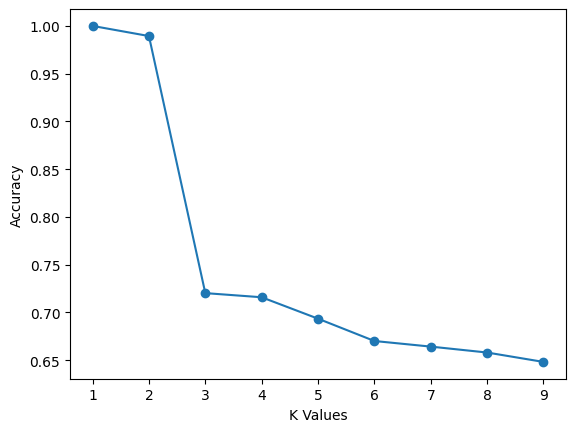

In [ ]:
knn_scores = []
for n in range(1,10):
    knn_model = KNeighborsClassifier(n_neighbors= n)
    #FIT MODEL
    knn_model.fit(x_train, y_train)
    knn_scores.append(knn_model.score(x_test, y_test))

plt.plot(range(1,10), knn_scores, marker = 'o')
plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
def evaluate_model(actual, pred):
    # Convert predictions to original labels if necessary
    if isinstance(pred[0], (int, np.integer)):  # Check if predictions are numeric (encoded)
        pred = encoder.inverse_transform(pred)  # Convert back to original labels

    report = classification_report(actual, pred)
    cm = confusion_matrix(actual, pred)
    accuracy = accuracy_score(actual, pred)
    return report, cm, accuracy

test_scores = []
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors= 3),
    "AdaBoost": AdaBoostClassifier(),
    "XGBOOST": XGBClassifier(),
}

In [ ]:
for name, model in models.items():
    if name == "XGBOOST":

        model.fit(x_train, y_train_encoded)
        test_pred = model.predict(x_test)
        # Convert XGBClassifier predictions back to original labels
        test_pred = encoder.inverse_transform(test_pred)
        train_pred = model.predict(x_train)
        # Convert XGBClassifier train predictions back to original labels
        train_pred = encoder.inverse_transform(train_pred)
    else:
        model.fit(x_train, y_train)
        test_pred = model.predict(x_test)
        train_pred = model.predict(x_train)


    # evaluation
    test_report, test_cm, test_accuracy = evaluate_model(y_test, test_pred)
    train_report, train_cm, train_accuracy = evaluate_model(y_train, train_pred)

    print(name)

    print("Model Training Performance")
    print("Train Accuracy = ", train_accuracy)
    print(train_report)
    print(train_cm)

    print("Model Testing Performance")
    print("Test Accuracy = ", test_accuracy)
    print(test_report)
    print(test_cm)
    print("\n")
    print("=" * 100)
    print("\n")

    test_scores.append(test_accuracy)


Logistic Regression

Model Training Performance

Train Accuracy =  0.7898

              precision    recall  f1-score   support



    Negative       0.83      0.83      0.83     40000

     Neutral       0.72      0.71      0.71     40000

    Positive       0.83      0.83      0.83     40000



    accuracy                           0.79    120000

   macro avg       0.79      0.79      0.79    120000

weighted avg       0.79      0.79      0.79    120000



[[33134  5766  1100]

 [ 5757 28347  5896]

 [ 1172  5533 33295]]

Model Testing Performance

Test Accuracy =  0.7867

              precision    recall  f1-score   support



    Negative       0.82      0.83      0.83     10000

     Neutral       0.71      0.70      0.71     10000

    Positive       0.82      0.83      0.83     10000



    accuracy                           0.79     30000

   macro avg       0.79      0.79      0.79     30000

weighted avg       0.79      0.79      0.79     30000



[[8304 1426  270]

 [147

In [ ]:
scores_df = pd.DataFrame(
    list(zip(models, test_scores)), columns=["Model", "Test Scores"]
)
scores_df

,Model,Test Scores
0,Logistic Regression,0.786700
1,Random Forest,0.999933
2,KNN,0.720200
3,AdaBoost,0.624133
4,XGBOOST,0.757733


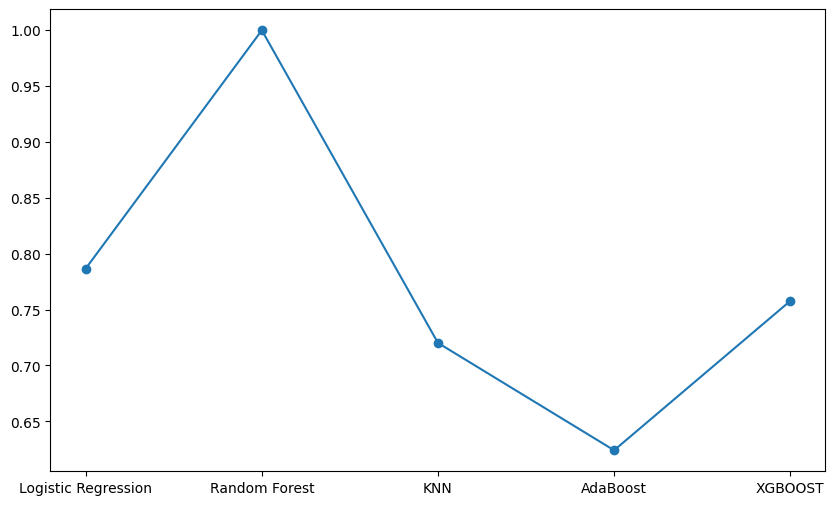

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(scores_df["Model"], scores_df["Test Scores"], marker="o")
plt.show()



**Apply Labelecnoder on "sentiment" Column**

In [ ]:
new_data['sentiment'] = encoder.fit_transform(new_data['sentiment'])
new_data.sample(5)

,text,sentiment
377335,times really get appeal place seems little hod...,0
609915,live previous reviews got mixed plate lamb ok ...,0
191663,awesome concept delivered horribly many intera...,0
536438,try downsides teriyaki bowls thin small portio...,1
455147,definitely see people fans place however boat ...,1


# **Split The Dataset**

In [ ]:
x = new_data["text"]
y = new_data["sentiment"]

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2 , shuffle = True)

# **Tokenize The Text**

In [ ]:
tokenizer = Tokenizer(num_words=16000)
tokenizer.fit_on_texts(x_train)

In [ ]:
tokenizer.word_index

{'n': 1,
 'food': 2,
 'good': 3,
 'place': 4,
 'like': 5,
 'get': 6,
 'one': 7,
 'time': 8,
 'would': 9,
 'great': 10,
 'service': 11,
 'go': 12,
 'back': 13,
 'really': 14,
 'us': 15,
 'got': 16,
 'ni': 17,
 'even': 18,
 'nthe': 19,
 'also': 20,
 'nice': 21,
 'ordered': 22,
 'well': 23,
 'much': 24,
 'people': 25,
 'order': 26,
 'could': 27,
 'came': 28,
 'restaurant': 29,
 'little': 30,
 'went': 31,
 'never': 32,
 'pretty': 33,
 'first': 34,
 'better': 35,
 'said': 36,
 'know': 37,
 'best': 38,
 'way': 39,
 'try': 40,
 'chicken': 41,
 'going': 42,
 'two': 43,
 'menu': 44,
 'bar': 45,
 'room': 46,
 'come': 47,
 'night': 48,
 'love': 49,
 'think': 50,
 'make': 51,
 'always': 52,
 'staff': 53,
 'vegas': 54,
 'bad': 55,
 'want': 56,
 'made': 57,
 'minutes': 58,
 'eerience': 59,
 'say': 60,
 'still': 61,
 'right': 62,
 'day': 63,
 'around': 64,
 'see': 65,
 'table': 66,
 'take': 67,
 'wait': 68,
 'eat': 69,
 'friendly': 70,
 'told': 71,
 'give': 72,
 'asked': 73,
 'another': 74,
 'since':

In [ ]:
# Sort the word_index by frequency (index values), and get the first 10 words
most_frequent_words = sorted(tokenizer.word_index.items(), key=lambda x: x[1])[:10]

# Extract just the words from the sorted list
most_frequent_words = [word for word, index in most_frequent_words]

print(f"The 10 most repeated words are: {most_frequent_words}")

The 10 most repeated words are: ['n', 'food', 'good', 'place', 'like', 'get', 'one', 'time', 'would', 'great']


In [ ]:
x_train[0]

'dr goldberg offers everything look general practitioner nice easy talk without patronizing always time seeing patients affiliated top notch hospital nyu parents elained important case something happens need surgery get referrals see specialists without see first really need sitting trying think complaints really drawing blank'

# **Vectorize The Text**

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [ ]:
x_train[0]

[7,
 3216,
 165,
 54,
 10,
 2,
 10,
 222,
 1491,
 1491,
 163,
 12,
 179,
 80,
 6380,
 49,
 693,
 95,
 166,
 80,
 1020,
 5,
 4114,
 466,
 1742,
 538,
 861,
 3370,
 138,
 5,
 1742,
 28,
 2572,
 4,
 2685]

# **Add Padding To The Text**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_length = 200
x_train = pad_sequences(x_train, maxlen=max_length)
x_test = pad_sequences(x_test, maxlen=max_length)

# **Build The LSTM Model**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train,validation_data=(x_test,y_test) , epochs=6, batch_size=64)

Epoch 1/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 361s 44ms/step - accuracy: 0.7330 - loss: 0.6295 - val_accuracy: 0.7812 - val_loss: 0.5413
Epoch 2/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 377s 43ms/step - accuracy: 0.7942 - loss: 0.4958 - val_accuracy: 0.7915 - val_loss: 0.5087
Epoch 3/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 357s 44ms/step - accuracy: 0.8106 - loss: 0.4543 - val_accuracy: 0.7964 - val_loss: 0.5047
Epoch 4/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 355s 44ms/step - accuracy: 0.8259 - loss: 0.4198 - val_accuracy: 0.7922 - val_loss: 0.4999
Epoch 5/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 395s 45ms/step - accuracy: 0.8407 - loss: 0.3848 - val_accuracy: 0.7932 - val_loss: 0.5116
Epoch 6/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 367s 43ms/step - accuracy: 0.8570 - loss: 0.3505 - val_accuracy: 0.7855 - val_loss: 0.5367


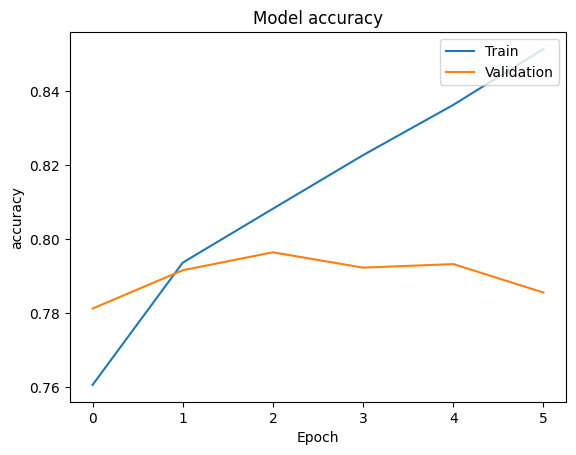

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

**We can See From This Plot The Overfitting**

# **Build Simple RNN Model**

In [ ]:
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
model_RNN.add(Bidirectional(SimpleRNN(128, return_sequences=True)))
model_RNN.add(Dropout(0.4))
model_RNN.add(Bidirectional(SimpleRNN(64)))
model_RNN.add(Dropout(0.7))
model_RNN.add(Dense(128, activation='relu'))
model_RNN.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_RNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_RNN.fit(x_train, y_train,validation_data=(x_test,y_test) , epochs=6, batch_size=64)

Epoch 1/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 740s 90ms/step - accuracy: 0.4751 - loss: 1.0133 - val_accuracy: 0.6712 - val_loss: 0.8007
Epoch 2/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 723s 89ms/step - accuracy: 0.6613 - loss: 0.8121 - val_accuracy: 0.6022 - val_loss: 0.8988
Epoch 3/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 753s 90ms/step - accuracy: 0.6274 - loss: 0.8690 - val_accuracy: 0.6287 - val_loss: 0.8727
Epoch 4/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 737s 90ms/step - accuracy: 0.6703 - loss: 0.8082 - val_accuracy: 0.6686 - val_loss: 0.8014
Epoch 5/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 740s 89ms/step - accuracy: 0.6783 - loss: 0.7875 - val_accuracy: 0.6927 - val_loss: 0.7537
Epoch 6/6
8125/8125 ━━━━━━━━━━━━━━━━━━━━ 745s 90ms/step - accuracy: 0.6860 - loss: 0.7715 - val_accuracy: 0.6972 - val_loss: 0.7410


**ًUnderfitting!**